# Lab 2 Solution

**Learning Objectives:**

- Use `numpy` arrays to perform calculations. (Code)
- Analyze airline pricing policies using simulation. (Code) 


# Case in Simulation Modeling: Pricing a Single Flight

Trojan airlines is examining its policy in pricing its LAX to SFO departure on Thursday evenings. The selling horizon is the 180 days before depature. Based on studies done by the marketing team, there are two main customer segments who purchase this flight. Below are some summary statistics.

Segment 1 ("Leisure" customers):

- Size of customer segment: mean 200, standard deviation 60
- Time of purchasing: approximately uniformly randomly from 180 days before departure to departure.
- Maximum willingness to pay: mean 200, st. dev. 80.

Segment 2 ("Business" customers):

- Size: mean 60, st. dev. 20.
- Time of purchasing: uniformly randomly from 14 days before departure to departure.
- Maximum willingness to pay: mean 350, st. dev. 120.

There are 100 seats on this flight (all economy class) and the fixed cost for operating each time is about $200,000.

Currently the price of the flight is held fixed throughout the 180 day selling horizon (from 180 days before departure to just before departure). However, the pricing manager would like to explore the potential benefits of implementing revenue management (RM) techniques to improve profits.

**RM policy 1:** increase the price for the last 14 days.

**RM policy 2:** increase the price after a certain number of tickets have been sold.

**You are hired to write a business report to the pricing manager to quantify the value of these more complex pricing strategies. **
 
You can use the normal distribution to approximate segment size and willingness to pay (aka valuation). For each pricing policy, you should assume that the price is a multiple of 5 dollars, and that the optimal such price is used. The following code provides a template for your analysis. The key is to write the four functions with `pass` as placeholders. Refer to the "numpy cheatsheet for commands that may be helpful."


In [69]:
from scipy.stats import norm,uniform
import numpy as np
import matplotlib.pyplot as plt
distN1=norm(200,60)
distN2=norm(60,20)
distBuyTime1=uniform(loc=0,scale=180)
distBuyTime2=uniform(loc=0,scale=14)
distValue1=norm(200,80)
distValue2=norm(350,120)
inventory=100
fixedCost=20000


def generateScenario():
    num1=int(max(0,distN1.rvs()))
    num2=int(max(0,distN2.rvs()))
    buyTimes1=distBuyTime1.rvs(size=num1)
    buyTimes2=np.maximum(0,distBuyTime2.rvs(size=num2))
    values1=distValue1.rvs(size=num1)
    values2=distValue2.rvs(size=num2)
    data=(np.vstack([np.hstack([buyTimes1,buyTimes2]),np.hstack([values1,values2])]))
    return data[:,(-data[0,:]).argsort()]
    
def simulatePrice(data,price):
    return min(inventory,np.sum(data[1]>=price))*price-fixedCost

def simulateRM1(data,price1,price2):
    vFirstPeriod=data[1,data[0]>14]
    vSecondPeriod=data[1,data[0]<=14]
    demand1=min(inventory,np.sum(vFirstPeriod>=price1))
    demand2=min(inventory-demand1,np.sum(vSecondPeriod>=price2))
    return price1*demand1+price2*demand2-fixedCost

def simulateRM2(data,price1,price2,quantity):
    curInv=inventory
    rev=0
    curPrice=price1
    for t,v in data.T:
        if curInv==quantity:
            curPrice=price2
        if v>=curPrice:
            curInv-=1
            rev+=curPrice
        if curInv==0:
            break
    return rev-fixedCost
    


In [71]:
# Code to test
data=generateScenario()
print('Generated scenario=\n',data)
print('Expected profit of constant price with price=235. profit=', simulatePrice(data,235))
print('Expected profit of RM1 policy with price1=200, price2=240 profit=', simulateRM1(data,200,240))
print('Expected profit of RM2 policy with price1=200, price2=240, quantity=50 profit=', simulateRM2(data,200,240,50))


Generated scenario=
 [[  1.79965544e+02   1.76487419e+02   1.75287365e+02   1.69048964e+02
    1.68914164e+02   1.66013731e+02   1.65909432e+02   1.65338361e+02
    1.64694739e+02   1.62566936e+02   1.62209191e+02   1.61976014e+02
    1.60100624e+02   1.58313867e+02   1.58251201e+02   1.57684833e+02
    1.57289792e+02   1.56021938e+02   1.55870184e+02   1.55424717e+02
    1.53649088e+02   1.50116696e+02   1.48835089e+02   1.47604038e+02
    1.46735891e+02   1.46498426e+02   1.45950951e+02   1.44947494e+02
    1.43206266e+02   1.40252298e+02   1.39159809e+02   1.38820583e+02
    1.38757096e+02   1.36325546e+02   1.32633569e+02   1.32460901e+02
    1.32266479e+02   1.31713953e+02   1.31368974e+02   1.30998829e+02
    1.30958458e+02   1.30603236e+02   1.30309452e+02   1.29352750e+02
    1.27578670e+02   1.27027808e+02   1.21885406e+02   1.18317405e+02
    1.12992256e+02   1.12120926e+02   1.11810465e+02   1.06718449e+02
    1.06391769e+02   1.03987696e+02   1.02212280e+02   1.01971099e+02

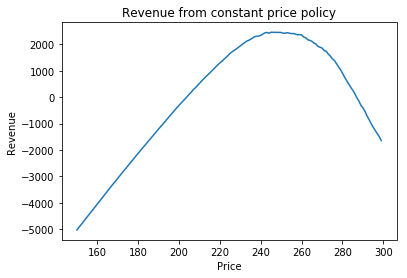

Best constant price = 245, best profit=2454.25


In [72]:
# Optimization analysis for best constant price

def analyzePrice():
    prices=range(150,300,1)
    np.random.seed(0)
    dataSet=[generateScenario() for t in range(100)]
    values=[np.average([simulatePrice(data,price) for data in dataSet]) for price in prices]
    plt.plot(prices,values)
    
    plt.title('Revenue from constant price policy')
    plt.xlabel('Price')
    plt.ylabel('Revenue')
    plt.show()
    index=values.index(max(values))
    
    print ('Best constant price = {0}, best profit={1}'.format(prices[index],values[index]))
        
    
analyzePrice()

In [73]:
def analyzeRM1():
    bestRev=0
    bestPrice1=0
    bestPrice2=0
    np.random.seed(0)
    dataSet=[generateScenario() for t in range(100)]
    for price1 in range(150,500,5):
        for price2 in range(price1,500,5):
            rev=np.average([simulateRM1(data,price1,price2) for data in dataSet])
            if rev>bestRev:
                bestRev=rev
                bestPrice1=price1
                bestPrice2=price2
    print ('2 Price policy: Best price1={0} Best price2={1}, Best profit={2}'.format(bestPrice1,bestPrice2,bestRev))
analyzeRM1()

2 Price policy: Best price1=235 Best price2=310, Best profit=3241.85


In [ ]:
def analyzeRM2():
    bestRev=0
    np.random.seed(0)
    dataSet=[generateScenario() for t in range(100)]
    for price1 in range(225,246,5):
        for price2 in range(290,331,5):
            for quantity in range(1,100):
                rev=np.average([simulateRM2(data,price1,price2,quantity) for data in dataSet])
                if rev>bestRev:
                    bestRev=rev
                    bestPrice1=price1
                    bestPrice2=price2
                    bestQuantity=quantity
                #print ('Best policy so far: price1={0} price2={1}, Quantity1={2}, Best profit={3}'.format(bestPrice1,bestPrice2,bestQuantity,bestRev))
    print ('Best capacity control policy: price1={0} price2={1}, Quantity1={2}, Best profit={3}'.format(bestPrice1,bestPrice2,bestQuantity,bestRev))
analyzeRM2()

# Numpy Arrays Cheatsheet

A numpy array is an object that stores blocks of numbers in a n efficient way. A one-dimensional array is a list of numbers. A two-dimensional array is a table of numbers. There can also be three or higher dimensional arrays. Below are some commonly used commands to manipulate arrays. See the comments in the code for explanation.

In [68]:
# Importing the numpy package
import numpy as np

# Creating arrays.
print('-----Creating numpy arrays-----------------')
X=np.zeros(5)               # a list of 5 zeros. 
Y=np.ones((2,3))            # 2 rows and 3 columns of ones.
Z=np.array([[1,2,3],[4,5,6]])  # 2 rows of numbers, with given number
J=np.array([1,0,0,1])       # A list of 4 numbers.
K=np.arange(2,13,2)        # Same as range, except for numpy arrays. The arguments are beginning number, ending number, interval
L=np.linspace(1,10,20)     # 20 points that interpolate between 1 and 10.
print('X={0}\n Y={1}\n Z={2}\n K={3}\n L={4}'.format(X,Y,Z,K,L))

# Indexing
print('\n------Indexing-------------------------')
print('Z=\n',Z)
print('K=\n',K)
print('Z[0,1]=',Z[0,1])       # Element in 0th row and 1st column
print('K[2]=',K[2])           # 3rd element
print('Z[1]=Z[1,:]',Z[1])           # The second row
print('Z[:,1]=',Z[:,1])       # The second column
print('J=',J)
print('Z[J,:]=',Z[J,:])       # access the given rows
print('Z[:,J]=',Z[:,J])       # access the given columns
print('K[:2]=',K[:2])         # Everything before the 3rd element.
print('K[2:]=',K[2:])          # Everything since the 3rd element.
print('K[1:3]=',K[1:3])          # From the 2nd up to before the 4th element.
print('Z[:,:2]=\n',Z[:,:2])      # all rows and everything up to 3rd column

# Element wise operation
print('\n----Element wise operations----------------')
print('Z+Y=\n',Z+Y)
print('Z-Y=\n',Z-Y)
print('Z*2=\n',Z*2)
print('Z/2=\n',Z/2)
print('Z/Z=\n',Z/Z)
print('Z>3=\n',Z>3)            # Create True/False array of whether each element is greater than 3
print('-Z=\n',-Z)
print('np.maximum(Z,3)=\n',np.maximum(Z,3))

# Simple statistics
print('\n-----Simple Statistics---------------------')
print('np.sum(Z)=',np.sum(Z))
print('np.average(Z)=',np.average(Z))
print('np.std(Z)=',np.std(Z))
print('np.max(Z)=',np.max(Z))
print('Z>3=',Z>3)
print('np.sum(Z>3)=',np.sum(Z>3))

# Manipulating
print('\n-----Manipulating---------------------')
print('Z=\n',Z)
print('Z.T=\n',Z.T)              # Transpose
X=np.copy(Z)
X[np.where(X>=3)]=3              # Set where X is larger or equal to 3 to 3.
print('X=np.copy(Z); X[np.where(X>=3)]=3')
print('X=\n',X)
print('np.hstack((Z,X))=\n',np.hstack((Z,X)))    # Horizontally stack two arrays together
print('np.vstack((Z,X))=\n',np.vstack((Z,X)))   # Vertically stack two arrays together
print('K=',K)
print('K.reshape((3,2))=\n',K.reshape((3,2)))
print('Z.shape=',Z.shape)
L=np.array([3,4,1,2])
print('L=',L)
print('np.sort(J))=',np.sort(L))
print('np.argsort(K)=',np.argsort(L))



# Iterating
print('\n------Iterating-------------')
print('Iterating through Z')
for row in Z:
    print(row)


-----Creating numpy arrays-----------------
X=[ 0.  0.  0.  0.  0.]
 Y=[[ 1.  1.  1.]
 [ 1.  1.  1.]]
 Z=[[1 2 3]
 [4 5 6]]
 K=[ 2  4  6  8 10 12]
 L=[  1.           1.47368421   1.94736842   2.42105263   2.89473684
   3.36842105   3.84210526   4.31578947   4.78947368   5.26315789
   5.73684211   6.21052632   6.68421053   7.15789474   7.63157895
   8.10526316   8.57894737   9.05263158   9.52631579  10.        ]

------Indexing-------------------------
Z=
 [[1 2 3]
 [4 5 6]]
K=
 [ 2  4  6  8 10 12]
Z[0,1]= 2
K[2]= 6
Z[1]=Z[1,:] [4 5 6]
Z[:,1]= [2 5]
J= [1 0 0 1]
Z[J,:]= [[4 5 6]
 [1 2 3]
 [1 2 3]
 [4 5 6]]
Z[:,J]= [[2 1 1 2]
 [5 4 4 5]]
K[:2]= [2 4]
K[2:]= [ 6  8 10 12]
K[1:3]= [4 6]
Z[:,:2]=
 [[1 2]
 [4 5]]

----Element wise operations----------------
Z+Y=
 [[ 2.  3.  4.]
 [ 5.  6.  7.]]
Z-Y=
 [[ 0.  1.  2.]
 [ 3.  4.  5.]]
Z*2=
 [[ 2  4  6]
 [ 8 10 12]]
Z/2=
 [[ 0.5  1.   1.5]
 [ 2.   2.5  3. ]]
Z/Z=
 [[ 1.  1.  1.]
 [ 1.  1.  1.]]
Z>3=
 [[False False False]
 [ True  True  True]]
-Z=
